# Arc Shaped Crack example

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors

from scipy.sparse.linalg import gmres

np.set_printoptions(precision=5, suppress=True)

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 15
plt.rcParams['text.usetex']=True
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["text.latex.preamble"] =r'\usepackage{amsmath}'+ r'\usepackage{amssymb}' + r'\usepackage{accents}'+ r'\usepackage{bm}'+ r'\boldmath'+ r'\renewcommand{\v}[1]{\boldsymbol{{#1}}}'+ r'\DeclareRobustCommand{\sot}[1]{\boldsymbol{{#1}}}'

norm1 = lambda a : np.linalg.norm(a, axis=1)
norm = lambda a : np.linalg.norm(a)

home = os.environ['HOME']

#change to the approprite bigwham directory and remember to place your notebook outside bigwham dir
sys.path.append(home + "/Desktop/GEL/BigWham/build/interfaces/python")
from hmatrix import Hmatrix  # linear operator file
os.environ["OMP_NUM_THREADS"] = "4"

In [2]:
def arc_crack_mesh(R, alpha, Nb=10, RefTipRatio=0.5, RefRatio=1):
    # Default Value such that mesh is uniform
    # RefRatio: Refinement ratio = (channel element size) / (tip element size)
    # RefTipRatio: ratio of refined tip to crack length, e.g., 0.2 for 20% tip refined
    # Nb: Number of Elements per fracture to get the base mesh size away from tips

    Nbt = max(round(RefRatio * Nb * RefTipRatio), 1)
    Nbc = max(round(Nb * (1 - 2 * RefTipRatio)), 1)

    Angle1 = np.linspace(-alpha, alpha * RefTipRatio, Nbt + 1)
    Angle3 = np.linspace(alpha, -alpha * RefTipRatio, Nbt + 1)[::-1]
    Angle2 = np.linspace(Angle1[-1], Angle1[-1] + 2 * alpha * (1 - 2 * RefTipRatio) / Nbc, Nbc - 1)
    Angle = np.concatenate((Angle1, Angle2, Angle3))

    coor = np.column_stack((R * np.cos(Angle), R * np.sin(Angle)))
    coor = np.unique(coor, axis=0)
    Ne = len(coor) - 1

    conn = np.array([[i, i + 1] for i in range(1, Ne + 1)])

    #return {"Coordinates": coor, "Connectivity": conn, "Nelts": Ne}
    return coor, conn, Ne

# Example usage with R=5, alpha=0.1, Nb=10, RefTipRatio=0.5, RefRatio=1
R = 5
alpha = 0.1
Nb = 10
RefTipRatio = 0.5
RefRatio = 1

coor, conn, Ne = arc_crack_mesh(R, alpha, Nb, RefTipRatio, RefRatio)
'''
print("Coordinates:")
print(mesh_data["Coordinates"])
print("\nConnectivity:")
print(mesh_data["Connectivity"])
print("\nNumber of elements:", mesh_data["Nelts"])
'''

'\nprint("Coordinates:")\nprint(mesh_data["Coordinates"])\nprint("\nConnectivity:")\nprint(mesh_data["Connectivity"])\nprint("\nNumber of elements:", mesh_data["Nelts"])\n'

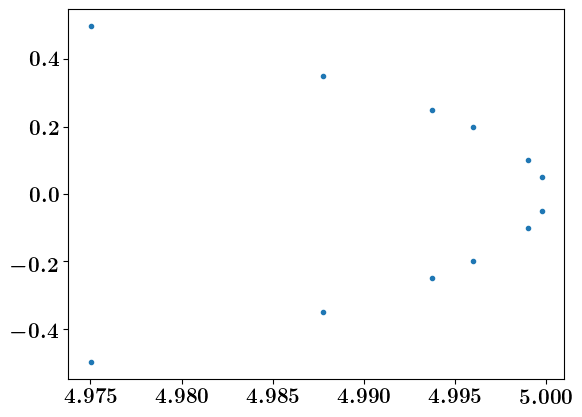

In [3]:
xcoor = coor[:, 0]
ycoor = coor[:, 1]

plt.plot(xcoor, ycoor, '.')
#plt.xlim([-1.1, 1.1])
#plt.ylim([-1, 1])

In [68]:
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

pre_fac = 2*((1 - nu)/G)

# Mesh
a = 1.0
nelts = 100
coor1D = np.linspace(-a, a, nelts + 1)
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

# H-matrix parameter
max_leaf_size=100
eta=3.
eps_aca=1.e-4

# Hmatrix
kernel = "2DP1"
elas_prop = np.array([E, nu])
hmat = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)


# get augemented collocation points
col_pts_aug = np.zeros((conn.shape[0] * 2, conn.shape[1]))
c = 0
col_pts_aug[c, :] = coor[0, :]
c += 1
for i in range(1, coor.shape[0] -  1):
    col_pts_aug[c, :] = coor[i, :]
    c += 1
    col_pts_aug[c, :] = coor[i, :]
    c += 1
col_pts_aug[c, :] = coor[i+1, :]

 Now setting things for kernel ... 2DP1 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  1.0009e-05
Binary cluster tree depth = 1
Number of blocks = 4
Number of full blocks = 4
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 4 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.00505651
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED


In [69]:
dd = np.zeros(col_pts_aug.shape)
dd[:, 1] = pre_fac * np.sqrt(a**2 - col_pts_aug[:, 0]**2)

print("Number of OMP threads {}".format(os.environ["OMP_NUM_THREADS"]))

# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts_aug.shape)
t_anal[:, 1] = pressure

Number of OMP threads 4


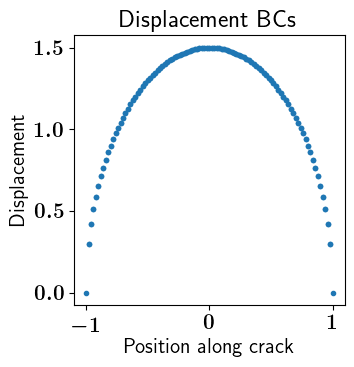

In [70]:
plt.plot(col_pts_aug[:, 0], dd[:, 1], '.')
plt.title("Displacement BCs")
plt.xlabel("Position along crack")
plt.ylabel("Displacement")
plt.show()

(-1.5, 1.5)

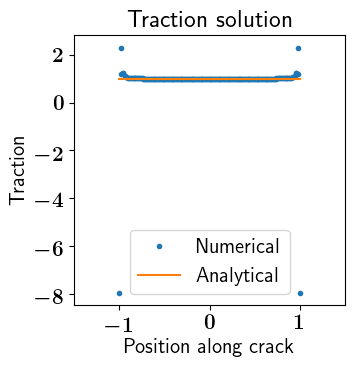

In [71]:
plt.plot(col_pts_aug[:, 0], t.reshape(-1, 2)[:, 1], ".")
plt.plot(col_pts_aug[:, 0], t_anal[:, 1])
plt.legend(["Numerical", "Analytical"])
# plt.xlim([-1 - 10 * 2 * c / nelts, -1 + 10 * 2 * c / nelts])
plt.title("Traction solution")
plt.xlabel("Position along crack")
plt.ylabel("Traction")
plt.xlim([-1.5, 1.5])

In [72]:
rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
print("L2 Rel error {}".format(rel_err))

L2 Rel error 0.03200679698622114


In [73]:
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)
sigma_A = 1.0

pre_fac = 2*((1 + nu)/G)

nelts_array = [10**i for i in range(1, 6)]
rel_error_array = []

# H-matrix parameter
max_leaf_size = 100
eta = 3.
eps_aca = 1.e-4

for nelts in nelts_array:
    # Mesh
    a = 10
    coor1D = np.linspace(-a, a, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

    # Hmatrix
    kernel = "2DP1"
    elas_prop = np.array([E, nu])
    hmat = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

    # get augemented collocation points
    col_pts_aug = np.zeros((conn.shape[0] * 2, conn.shape[1]))
    c = 0
    col_pts_aug[c, :] = coor[0, :]
    c += 1
    for i in range(1, coor.shape[0] -  1):
        col_pts_aug[c, :] = coor[i, :]
        c += 1
        col_pts_aug[c, :] = coor[i, :]
        c += 1
    col_pts_aug[c, :] = coor[i+1, :]

    dd = np.zeros(col_pts_aug.shape)
    dd[:, 1] = pre_fac * np.sqrt(a**2 - col_pts_aug[:, 0]**2)

    # calculate tractions
    t = hmat.matvec(dd.flatten())

    t_anal = np.zeros(col_pts_aug.shape)
    t_anal[:, 1] = pressure

    rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
    print("L2 Rel error {}".format(rel_err))
    rel_error_array.append(rel_err)

 Now setting things for kernel ... 2DP1 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  8.47e-07
Binary cluster tree depth = 0
Number of blocks = 1
Number of full blocks = 1
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.000877677
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED
L2 Rel error 0.17023210243644302
 Now setting things for kernel ... 2DP1 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  2.543e-06
Binary cluster tree depth = 1
Number of blocks = 4
Number of full blocks = 4
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 4 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of 

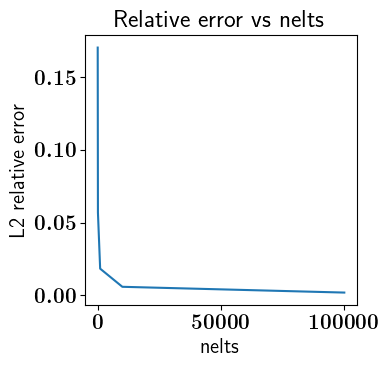

In [74]:
plt.figure()
plt.plot(nelts_array, rel_error_array)
plt.title("Relative error vs nelts")
plt.xlabel("nelts")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

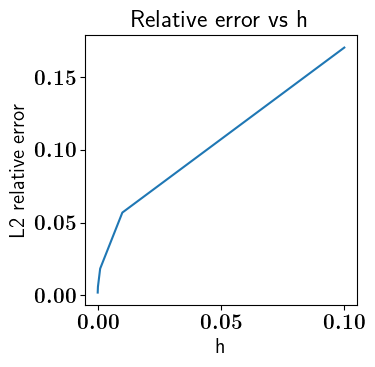

In [75]:
h_array = [1/nelts for nelts in nelts_array]

plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Relative error vs h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

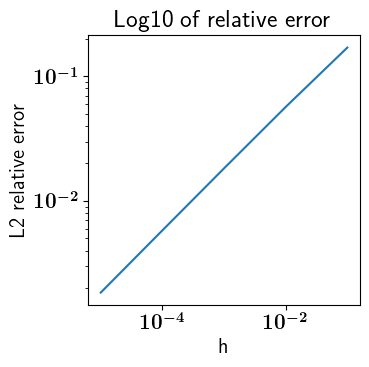

In [76]:
plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Log10 of relative error")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log')
plt.xscale('log')
#saves fig - remember to remove
#plt.savefig('log_rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

In [77]:
print(h_array)
print(rel_error_array)

[0.1, 0.01, 0.001, 0.0001, 1e-05]
[0.17023210243644302, 0.05682733779930854, 0.01827686699127739, 0.005811000689234393, 0.0018407616065660914]


In [78]:
log_h = np.log(np.asarray(h_array)[2:])
log_rel_array = np.log(np.asarray(rel_error_array)[2:])

m, c = np.polyfit(log_h, log_rel_array, 1)

print(m)
print(c)

0.49845210189069505
-0.5583189762226293


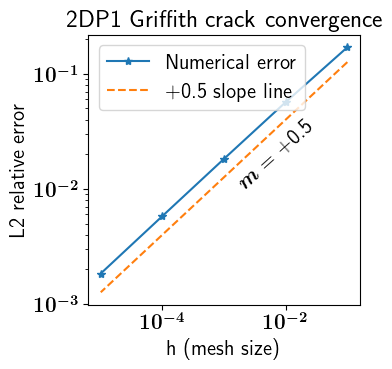

In [79]:
plt.figure()
plt.plot(h_array, rel_error_array, "*-")
plt.plot(h_array, 0.4*np.array(nelts_array) ** (-0.5) , "--")
plt.title("2DP1 Griffith crack convergence")
plt.text(0.0015, 0.01, r'$m$' + ' = +0.5', rotation=42)
plt.legend(["Numerical error", "+0.5 slope line"])
plt.xlabel("h (mesh size)")
plt.ylabel("L2 relative error")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
#saves fig - remember to remove
# plt.savefig('log2_rel_err_h.png', dpi=100, bbox_inches='tight')
# plt.show()